# Random scores and their losses for binary classification
- Work with randomly distributed feature and target data $(x,y)$ taking values in $\in\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ we make for $y$
- Classification is the case where $\mathcal Y$ is a finite set $\#\mathcal Y=N_{\texttt{lab}}<\infty$ of possible target label values - statistics about such models take discrete values but the random setting means that objectives can be related in a natural way to continuous valued functions
$\newcommand\dee{\mathrm{d}}
\newcommand\LBCE{\widetilde{\mathrm{BCE}}}
\newcommand\SBCE{\widehat{\textrm{BCE}}}
\newcommand\rs{\texttt{rs}}$


### Possible scores for a single prediction
- Feature and target data $(x,y)$ taking values in $\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ for $y$
- Generallity allow predictions to depend on varying costs of misclassifications
- To compute some statistic $c$ about a classification a user first has to fix some function of the possible prediction and outcomes $(\hat y,y)\in\mathcal Y^2$
- For classification any such function can be represented by its values on the $N^2$ possible outcomes so that $c=C_s(\hat y,y)$ where $s$ is an RV taking values in a finite dimensional space of parameters $\Sigma$
- Assuming a misclassification is always worse than a correct classification, we can rescale by eg subtracting any profits that would be gained from a correct prediction and restrict to an $N^2-N$ dimensional family of misclassification costs
- For binary classification $N=2$ this means that up to a rescaling there are only two degrees of freedom for possible prediction-outcome pairs and the random statistic can be written
$$
c=C_\sigma(\hat y,y)
$$
where $\sigma_-=C_\sigma(+,-)$ and $\sigma_+=C_\sigma(-,+)$ are the costs of a false positive and false positive respectively
- For fixed sampled value of $\sigma$ can write down a Bayes rule in terms of the marginals
$$
y^*(x',\sigma)=\begin{cases}+\text{ if }\rho(x')=\frac{\mathbb P(+|x=x')}{\mathbb P(-|x=x')}>\frac{\sigma_+}{\sigma_-},\\-\text{ otherwise}\end{cases}
$$
    - This means that for a fixed $\kappa=\frac{\sigma_+}{\sigma_-}$ the optimal solution just checks whether the relative likelihood is greater than $\kappa$

### Theory and practice
- We will find that in this case it is a bad idea to assume that a model trained using BCE is well calibrated in that its outputs behave akin to a marginal distribution
- This isn't necessarily a problem - such a model may still be useful - it is straightforward to use the training data to pick a cutoff that minimises expectations for a given cost ratio

# First experiments
First dataset to work with is cybersecurity: UNSW-NB15

In [1]:
from cal.dl import unsw
#data_unscaled=unsw(lab_cat=True,rescale=False)
data_rescaled=unsw(lab_cat=True,rescale=True)

- Depending on experimental procedure, need to split data etc, here: train-test split

In [2]:
(x_train,all_classes_train),(x_test,all_classes_test),(df_train,df_test),sc=data_rescaled


- First consider boring case where $\sigma$ is constant
- Rescaling $C$ by a constant doesn't change problem, can parameterise by a single number eg common choice $\beta^2=\frac{\sigma_-}{\sigma_+}$ or similar
- Can write expected cost for fixed feature $x=x'$ and prediction $\hat y=y'$ which we wish to minimise in expectation
$$
\mathbb E(C(y,y')|x=x')=\sigma_{-y'}\mathbb P(y=-y'|x=x')
$$

This has multiple classes, focus on one class for now:

In [3]:
y_train,y_test=all_classes_train=='Generic',all_classes_test=='Generic'
generic=dict(x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,
             cost_rats=[1,2,4,8,10,50,100],ds_name='unsw',plot_title='NN trained on UNSW')

### BCE
- Write $(\Omega,\mathbb P,\sigma)$ for underlying random system
- Let $x$ and $y$ be RVs taking values in $\mathcal X$ and $\mathcal Y$, which we formally treat as maps from $\Omega$:
$$
\Omega\xrightarrow{x\times y}\mathcal X\times\mathcal Y
$$
- Interested in dependence of $y$ upon $x$
- Intuitively, if $y$ is in large part dependent upon the value of $x$, then there exists a model $\hat y(x)$ such that $\hat y\approx y$ in an appropriate sense
- If the user has access to everything is possible to represent $y$ as a random variable $z:\Omega\times\mathcal X\rightarrow\mathcal Y$ trivially by letting $z(\omega,x')=y(\omega)$, but we assume that they only have access to a factor $\Pi:\Omega\rightarrow\Omega'$ of $\Omega$ such that $x$ and $y$ are independent of $\Pi$.
- If we consider the RVs $u=(x,y)$ and $v=(x,z)$ representing a true system and an associated model their cross entropy is defined as
$$
H(u,v)=-\int_{\mathcal X\times\{\pm\}} f_u(x',y')\log(f_v(x',y'))\dee x'\dee y'
$$

BCE minimisation: given sampled features $x_j\in\mathcal X$ for $j\in I$ with corresponding targets $y_i\in\{\pm\}$ write $\tilde y=f_z(x)$.
Let $i$ be uniformly distributed in $I$, so that $x_i$ and $y_i$ are distributed empirically.
The sample cross entropy is the cross entropy of the RVs
$$
H((x_i,y_i),(x_i,z(x_i)))=\SBCE((f_z(x_i),y_I)=\SBCE((f_z(x_i),y_I)=-\frac1{\#I}\sum_{j\in I}1_{y_i=+}\log(f_z(x_i))+1_{y_i=-}\log(1-f_z(x_i))
$$
and used as basis for gradient descent etc.

### NN output interpreted as a log relative likelihood
- Write $\rho$ for the output of a $NN$
- Needn't have $0\leq\rho\leq 1$, implementations in ML might allow any value and transform to probabilities only as necessary
- Probability and log relative likelihood can both be used - find the latter arises in ML.
- If $\rho$ can take any real value the log relative likelihood is a better candidate.
- The associated probability can then be expressed
$$
\tilde y=\sigma(\rho).
$$
- Write $\varphi(t)=-\log(\sigma(t))$
- The BCE expressed in terms of the log likelihood then takes the form 
$$
\LBCE(\rho,y)=\SBCE(\sigma(\rho),y)=\begin{cases}\varphi(\rho)\text{ when }y=+\text{ and}\\\varphi(-\rho)\text{ otherwise}\end{cases}
$$
- Indeed this is the actual definition of $\texttt{sigmoid}\_\texttt{binary}\_\texttt{cross}\_\texttt{entropy}$ provided by optax.

### Loss asymptotics I: BCE
- Want to check asymptotics at high and low uncertainty.
- By calculus
$$
\varphi(t)\sim\begin{cases}e^{-t}\text{ for }t\gg0\text{ and}\\ t\text{ for }t\ll0\end{cases}
$$
- If $y=0$ and $t\gg 0$ then
$$
\partial_z\SBCE(\sigma(t))=-\log(1-\sigma(t))\approx-\log(1-(1-e^{-t}))=-t
$$
and
$$
\partial_z\SBCE(\sigma(-t))=-\log(1-\sigma(-t))\approx-\log(1-e^{-t})\approx e^{-t}
$$
- Symmetrically when $y=1$ we have
$$
\partial_t\SBCE(\sigma(t))\approx e^{-t}\text{ and }\partial_t\SBCE(\sigma(t))\approx t
$$
Asymptotically
- Size of gradient decays exponentially as $t$ moves in the direction of the correct prediction
- Constant gradient for $t$ badly wrong


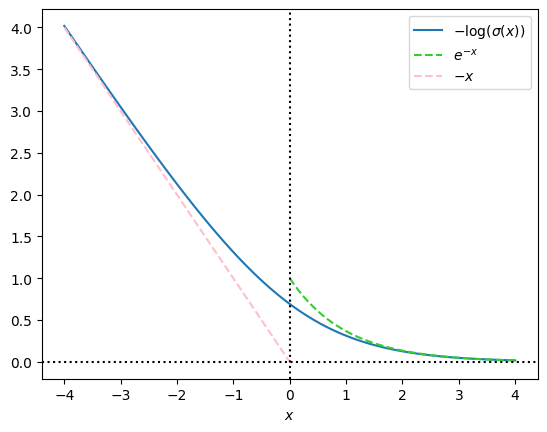

In [4]:
from matplotlib.pyplot import plot,show,legend,xlabel,ylabel,axvline,axhline,title

from jax.numpy import linspace,log,exp
def plot_asymptotics(f,f_lab,f_p,f_p_lab,f_n,f_n_lab,sh=True,
                     x=linspace(-4,4,100),xp=linspace(0,4,50),xn=linspace(-4,0,50)):
  plot(x,f(x),label=f_lab)
  plot(xp,f_p(xp),color='limegreen',linestyle='dashed',label=f_p_lab)

  plot(xn,f_n(xn),color='pink',linestyle='dashed',label=f_n_lab)
  xlabel('$x$')
  axvline(c='black',linestyle='dotted')
  axhline(c='black',linestyle='dotted')
  legend()
  if sh:
    show()

phi=lambda t:-log(1/(1+exp(-t)))
phi_p=lambda x:exp(-x)
phi_n=lambda x:-x

plot_asymptotics(phi,'$-\\log(\\sigma(x))$',phi_p,'$e^{-x}$',phi_n,'$-x$')

## Experiment 0
### Experiment 0.1: BCE on raw data
- Here we train with BCE and measure performance against a range of possible cost ratios
- Want to test effects of common resampling techniques

In [5]:
from cal.rs import resamplers_list

from cal.jal import NNPL

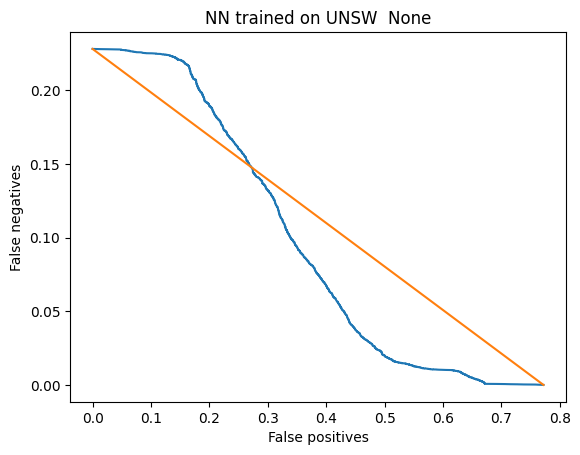

FPFNComplex(cutoff=Array([-3.8828878, -3.8529482, -3.472118 , ...,  1.5900844,  1.7733871,
        1.8142623], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-3.8828878 -3.8529482 -3.472118  ...  1.5900844  1.7733871  1.8142623]


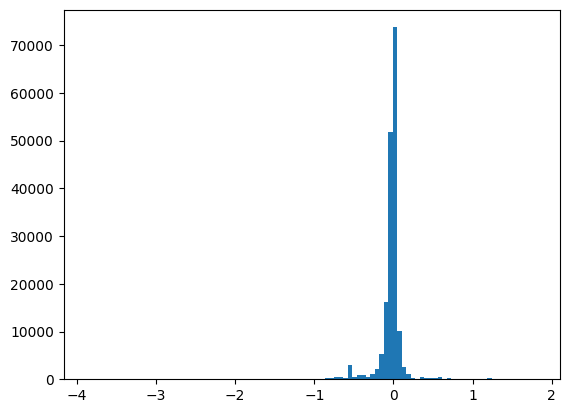

In [6]:
nn_bce=NNPL(**generic)

nn_bce.mk_preds()
nn_bce.results()
nn_bce.plot()

Resampling took 0 seconds
Completed 100 epochs in 12.246368377998806 seconds
Getting fp-fn characteristic
cost_ratio    fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0258867     0.007277248   0.02169266    0.06776223    0.08945489    
2             0.029502511   0.0052754343  0.025154255   0.02939319    0.059354994   
4             0.029502511   0.0052754343  0.025154255   0.02939319    0.07136351    
8             0.030032907   0.005201293   0.025409319   0.027036875   0.08545538    
10            0.031652607   0.005030198   0.027073314   0.01827965    0.06636666    
50            0.038268287   0.004659492   0.032587573   0.009425255   0.07125519    
100           0.038268287   0.004659492   0.032587573   0.009425255   0.09751131    


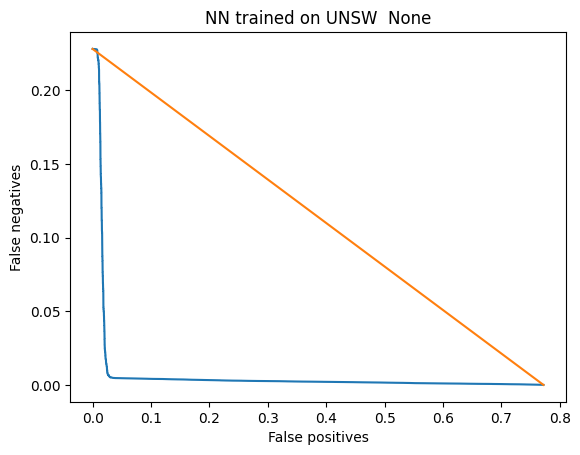

FPFNComplex(cutoff=Array([-1.7569023, -1.7181264, -1.6712855, ..., -1.0397604, -1.0378696,
       -1.0332804], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.1406345e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-1.7569023 -1.7181264 -1.6712855 ... -1.0397604 -1.0378696 -1.0332804]


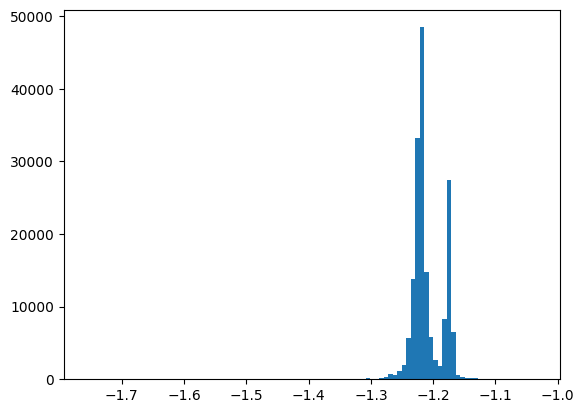

In [7]:
nn_bce.fit()
nn_bce.report()
nn_bce.plot()

- Not well calibrated (Bayes rule for threshold is useless) but not a problem really

### Experiment 0.2: Effects of resampling schemes on BCE
- Common to try using various resampling schemes during training
- Such a scheme takes dataset $D=(x^{(i)},y^{(i)})$ and transforms it to $D_\rs=(x_\rs^{(i)},y_\rs^{(i)})$
- Idea: address issues that arise from imbalance (note this framing is contentious in literature, with some taking a view that particularly hard problems described in this way may be better understood as a problem of limited data)

In [8]:
print(resamplers_list)

['NearMiss', 'SMOTEENN', 'ADASYN', 'SMOTE', 'SMOTETomek', '']


#### Cost loss?
- Probablistically BCE loss analogous to learning likelihoods over wide range - use cases include high uncertainty in future costs
- Fixing costs is in a sense at other extreme of possible approaches - all we care about is whether likelihoods are above a set threshold
- Costs $\chi_\pm$ for false negatives and false positives have an associated loss with constant gradient with respect to $\tilde y$ for fixed $y'\in\{\pm\}$,
$$
C_\chi(\tilde y,y)=\chi_+1_{y=+}(1-\tilde y)+\chi_-1_{y=-}\tilde y
$$
so that gradients in the direction of the correct label are scaled by some notion of importance of each class.
When reframed as a function of the density this becomes
$$
\widetilde C_\chi(\rho,y)=\chi_+1_{y=+}\sigma(-\rho)+\chi_-1_{y=-}\sigma(\rho)
$$

Resampling data with method NearMiss ...
NearMiss doesn't take a random seed...
Resampling took 8.161552494999341 seconds
Completed 100 epochs in 6.552201682001396 seconds
Getting fp-fn characteristic
cost_ratio    fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.037561093   0.005885674   0.030328428   0.020040812   0.05036924    
2             0.03830821    0.0053039505  0.032126028   0.014733032   0.043552186   
4             0.038730245   0.005104339   0.032551136   0.01366419    0.04360395    
8             0.03981955    0.004933244   0.03445805    0.011732984   0.04536865    
10            0.03981955    0.004933244   0.03445805    0.011732984   0.047999546   
50            0.041792847   0.004824884   0.036838654   0.010445514   0.07907071    
100           0.11061873    0.0040549557  0.09430113    0.007469757   0.08412769    


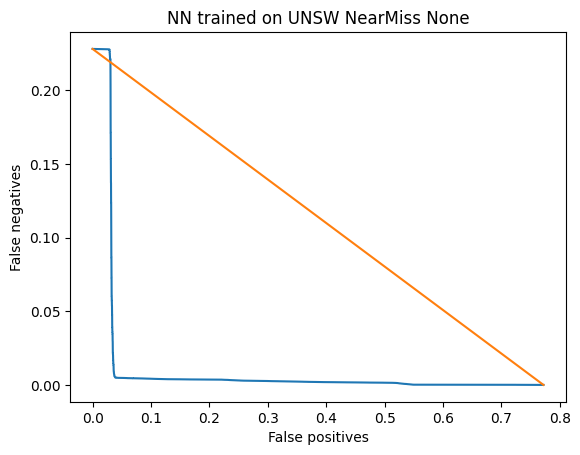

FPFNComplex(cutoff=Array([-0.17528604, -0.17505242, -0.15982935, ...,  0.3012958 ,
        0.30129895,  0.3013689 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-0.17528604 -0.17505242 -0.15982935 ...  0.3012958   0.30129895
  0.3013689 ]


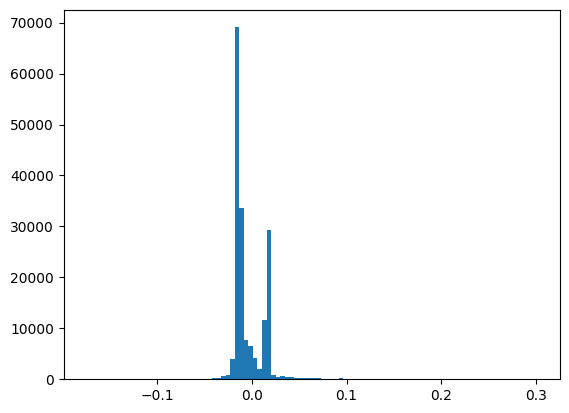

Resampling data with method SMOTEENN ...
Resampling took 110.1040736140003 seconds
Completed 100 epochs in 19.297900056999424 seconds
Getting fp-fn characteristic
cost_ratio    fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.00030797132 0.005047308   0.0002915027  0.008672206   0.008963709   
2             0.00030797132 0.005047308   0.0002915027  0.008672206   0.012470474   
4             0.00030797132 0.005047308   0.0002915027  0.008672206   0.017490163   
8             0.00030797132 0.005047308   0.0002915027  0.008672206   0.024631763   
10            0.00030797132 0.005047308   0.0002915027  0.008672206   0.027516104   
50            0.080722705   0.000695787   0.0028300055  0.008611476   0.061292555   
100           0.080722705   0.000695787   0.0028300055  0.008611476   0.08639776    


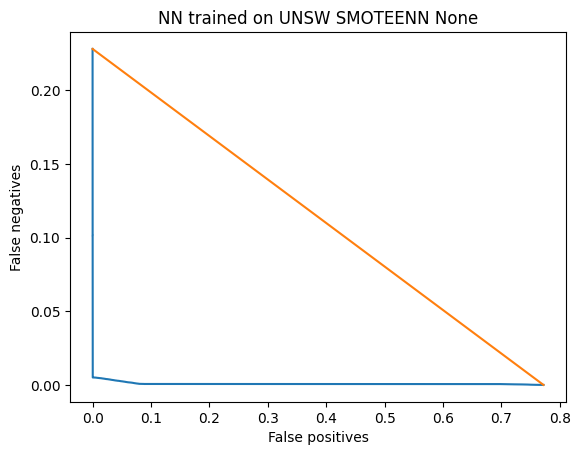

FPFNComplex(cutoff=Array([-0.03036133, -0.02232381, -0.02232381, ...,  0.0173042 ,
        0.0173042 ,  0.0173042 ], dtype=float32), fp_rate=Array([0.77187306, 0.7718674 , 0.7718617 , ..., 0.        , 0.        ,
       0.        ], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.2281155 , 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-0.03036133 -0.02232381 -0.02232381 ...  0.0173042   0.0173042
  0.0173042 ]


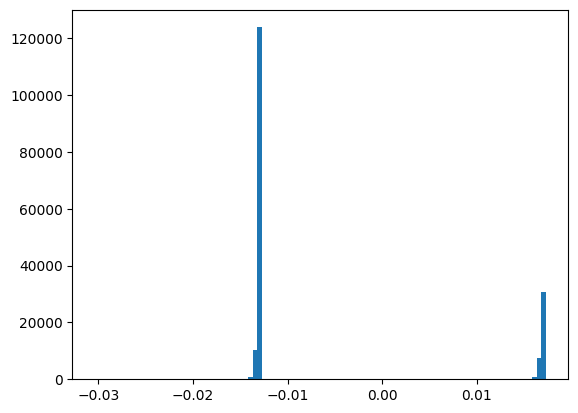

Resampling data with method ADASYN ...


In [ ]:
#nns={}
for rs in resamplers_list:
  #nn=NNPL(x_train,y_train,x_test,y_test,sigmoid_binary_cross_entropy,'unsw')
  nn_bce.fit(rs=rs)
  nn_bce.report(rs=rs)
  nn_bce.plot(rs=rs)
  #nns[rs]=nn

In [ ]:

### Experiment 0.2: Cost
#def mk_cost(cr):
#  def cost(pred,targ):
#    return cr*targ*sigmoid(-pred)+(1-targ)*sigmoid(pred)
#  return jit(cost)

#print('Training on cost...')
#for cr in cost_rats+[200,400]:
#  nn=NNPL(x_train,y_train,x_test,y_test,mk_cost(cr))
#  nn.epochs()
#  nn.report(cost_rats)
#  nn.plot('NN trained on UNSW with cost for ratio '+str(cr))

# General classifier losses as weighted sums of costs
- At a glance seems cost may be useless - but any loss of interest can be written as a sum of all possible costs



## Expected misclassification cost 
In a random formulation eg per https://link.springer.com/article/10.1007/s10994-024-06634-8 we seek to minimise $c$ in expectation:
$$
\mathbb E(c)=\int_{\Sigma\times\mathcal X\times\mathcal Y} C_\sigma(y',\hat y_{\sigma'}(x'))\dee\mathbb P(\sigma',x',y')
$$
Try their losses - but might be the case that most important aspect of analysis is asymptotic behaviour of losses


### Beta losses

- Authors let positive and negative costs be gamma RVs with parameters $(\alpha,\theta)$ and and obtain an expected misclassification cost proportional to
\begin{align*}
L_{\alpha\beta}(\tilde y,y)=&\int_0^{\tilde y}(t-y)t^{\alpha-1}(1-t)^{\beta-1}\dee t\\
=&\begin{cases} -\int_0^{\tilde y}t^{\alpha-1}(1-t)^\beta\dee t\text{ if }y=+,\\
\int_0^{\tilde y}t^\alpha(1-t)^{\beta-1}\dee t\text{ otherwise}\end{cases}\\
=&B(\alpha+(1-y),\beta+y;\tilde y)\\
=&B(a,b,\tilde y)\text{ for convenience}
\end{align*}
- $B$ is well known - the (incomplete) beta function 


### Loss asymptotics II: Beta loss at high certainties
- $a$ and $b$ describe the asymptotic order of $B(a,b,t)$ for $t\approx0$ and $t\approx 1$ respectively
- Specifically can check that
$$
B(a,b,t)\sim\begin{cases}O\left(\begin{cases}t^a\text{ if }a>0\\\log(t)\text{ if }a=0\end{cases}\right)\text{ when }0\approx t\ll1,\\O\left(\begin{cases}(1-t)^b\text{ if }b>0\\\log(1-t)\text{ if }b=0\end{cases}\right)\text{ when }0\ll t\approx1\end{cases}
$$


- This behaviour is mirrored in the log likelihood picture, where
$$
\widetilde B(a,b,\rho)\sim\begin{cases}
O\left(\begin{cases}
e^{\rho a}\text{ if }a>0\\
\rho\text{ if }a=0
\end{cases}\right)\text{ when }\rho\ll0,\\
O\left(\begin{cases}
e^{-\rho b}\text{ if }b>0\\
-\rho\text{ if }b=0
\end{cases}\right)\text{ when }\rho\gg0
\end{cases}
$$

- which means that
$$
\widetilde L_{\alpha\beta}(\rho,+)=\tilde B(\alpha,\beta+1;\rho)\sim
\begin{cases}
O(-e^{\rho\alpha})\text{ if }\alpha>0,~y=+\text{ and }\rho\ll0\\
O(-\rho)\text{ if }\alpha=0,~y=+\text{ and }\rho\ll0\\
O(e^{\rho(\beta+1)})\text{ if }~y=+\text{ and }\rho\gg0\\
\end{cases}
$$

- The parameters $\alpha$ and $\beta$ are not directly related to any single value of cost and should be taken to describe the tail risk associated with each type of error
- This is in line with the consequences of different decisions eg in the case of cybersecurity - legitimate traffic on a network being blocked may cause serious problems in the short term, but doesn't typically have the risks associated with malicious actors being able to access a network.

### Loss asymptotics III: Beta loss for small $\alpha$ and $\beta$ as perturbations of BCE
- From above discussion view $\alpha$ and $\beta$ as controlling the cost uncertainty for false negative and false positive
- Need each of $a$ and $b$ in the above expression to be nonnegative, whence it is necessary that $(\alpha,\beta)\in[0,\infty)^2$
- Can check by substitution that $B(a,b;c)=B(b,a,1-c)$ and $B(-1,0;\tilde y)=\log\tilde y$
- It follows that $L_{00}=\SBCE$
- If $\alpha$ and $\beta$ are small this is a parameterised perturbation of the BCE - in order for the loss to be well defined both $\alpha$ and $\beta$ must be nonnegative so the BCE can be seen is a limit as uncertainty in the positive and negative costs diverges
- Initially fix $\alpha$ and try small values of $\beta$ - this corresponds to assuming increasingly thin tails on the uncertainty in the cost of a false positive

### Numerical instability for provided beta functions
- Naively trying out this map doesn't go well
- doesn't seem particularly numerically stable over range of interest, so this is unsurprising
- Could just write down a desired gradient directly or choose another perturbation of BCE in the direction of higher cost certainty - we will do the latter

In [ ]:
# For now, just use $\alpha=10^{-1}$ and scale $\beta$ - should investigate numerical stability further though...
from jax.scipy.special import betainc
from jax.scipy.stats.beta import cdf
from jax.numpy import geomspace
from jax.nn import sigmoid
Ir=linspace(-4,4,200)
betas=geomspace(.1,10,10)
alpha_small=.1
for b in betas:
  
  l=cdf(sigmoid(Ir),alpha_small,b+1)
  l/=(l.max()-l.min())
  l-=l.min()
  plot(Ir,l,label='beta='+str(round(100*b)/100))
l=log(sigmoid(Ir))
l/=(l.max()-l.min())
l-=l.min()
plot(Ir,l,label='log(sigmoid(rho))',c='black',linestyle='dotted')
xlabel('predicted log relative likelihood')
title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+ (rescaled)')
legend()
show()

Ip=linspace(0,1,200)
for b in betas:
  l=cdf(Ip,alpha_small,b+1)
  plot(Ip,l,label='beta='+str(round(100*b)/100))

title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+')

xlabel('predicted probability')
show()

def mk_fp_relaxed_beta_loss(beta,alpha_small=alpha_small):
  def beta_loss(pred,targ):
    return betainc(alpha_small+1-targ,beta+targ,sigmoid(pred))
  
  return jit(beta_loss)
    

In [ ]:

Ir=linspace(-4,4,200)
betas=1.+geomspace(.01,1,10)
for a in [1e-6,1e-5,1e-4,1e-3,1e-2]:
  for b in betas:
    plot(Ir,betainc(a,b,sigmoid(Ir)),label='beta='+str(round(1000*b)/1000))
  title('Beta loss as a function of predicted likelihood with alpha=1e'+str(round(log(a)/log(10)))+\
        ' and beta increasing for y=+')
  legend()
  show()

Ip=linspace(0,1,200)
for b in betas:
  plot(Ip,betainc(0,b,Ip))
title('Beta loss as a function of predicted probability with alpha=0 and beta increasing for y=+')
show()


- Still seems pretty bad - and get nans upon training


In [ ]:
nn_beta=NNPL(loss=mk_fp_relaxed_beta_loss,**generic)
betas=[0,1e-5,1e-4,1e-3,1e-2,1e-1,1.,10.]
#for beta in geomspace(beta_large,beta_small,10):
#  nn_beta.fit(loss_param=float(beta))
#  nn_beta.report(loss_param=float(beta))
#  nn_beta.plot(loss_param=float(beta))

### Loss asymptotics III: a simple modification
- The core of the idea behind the loss proposed by https://link.springer.com/article/10.1007/s10994-024-06634-8 is that different loss choices relate to different cost uncertainties - higher $\alpha$ and $\beta$ values correspond to thinner tails on cost
- as a simple in silico alternative, we modify binary cross entropy by exponentiating $\sigma(\rho)$ rather than taking logarithms when $y$ is $\boldsymbol -$, which corresponds to lower tail risk associated with false positives
$$
L_{\theta}(\rho,y)=\begin{cases}-\log(\sigma(\rho))\text{ if }y=\boldsymbol+,\\\theta^{-1}(\sigma(\rho))^\theta\text{ otherwise}\end{cases}
$$

In [ ]:
from cal.jal import make_fp_perturbed_bce

## Training with BCE for various small values of $\beta$

In [ ]:
nn_g=NNPL(loss=make_fp_perturbed_bce,**generic)

for beta in betas:
  nn_g.fit(loss_param=float(beta))
  nn_g.report(loss_param=float(beta))
  nn_g.plot(loss_param=float(beta))

### Perturbed BCE+resampling